In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt 
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

In [1]:
class Processing:
    def __init__(self, currency, begining_training, end_training,end_testing, timestamp, features, target):
        self.timestamp = timestamp
        self.currency = currency
        self.features  = features
        self.begining_training = begining_training
        self.end_training = end_training
        self.end_testing = end_testing
        self.df  = self.importDataset()
        self.x_train = []
        self.y_train = []
        self.x_test  = []
        self.y_test  = []
        self.scaler_x = None
        self.scaler_y = None
        self.target = target
        self.df_training =  None
        self.df_test = None
        self.splitData()
    
    def importDataset(self):
        parser = lambda x: pd.datetime.strptime(x, "%Y.%m.%d %H:%M:%S")
        df = pd.read_csv( 'arquivos_de_coleta/'+self.currency+'.csv', sep=';', header=0, parse_dates=['time'],date_parser=parser) 
        return df
    
    def selectInterval(self, start, end):
        mask = (self.df['time'] > start) & (self.df['time'] <= end )
        return self.df.loc[mask]
    
    def scalerDataset(self, dataset):
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.scaler_x.fit(dataset)
        self.scaler_y.fit(self.df_training[[target]])
        return self.scaler_x.transform(dataset)

    def processXY(self, dataframe):
        length = len(dataframe)
        x_data = []
        y_data = []
        for i in range(self.timestamp, length):
            x_data.append( dataframe[i-self.timestamp:i,:])
            y_data.append( dataframe[i,self.features.index(target)])
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        x_data = np.reshape(x_data, (x_data.shape[0], self.timestamp, len(features)))
        return x_data, y_data
     
    def splitData(self):
        #Selecionando Intervalos de datas para treino
        self.df_training = self.selectInterval(self.begining_training, self.end_training)
        #selecionando colunas para treino
        self.df_training = self.df_training[self.features]
        #Escalando o dataset de treino usando a funcao MinMax()
        self.x_train = self.scalerDataset(self.df_training)
        #Processando o dataset com o shape adequado para a modelagem 
        self.x_train, self.y_train = self.processXY( self.x_train )
        #Selecionando Intervalos de datas para teste
        self.df_test = self.selectInterval(self.end_training, self.end_testing)
        #selecionando colunas do dataset para teste
        self.x_test = self.df_test[self.features]
        #Escalando o dataset de treino
        self.x_test = self.scaler_x.transform(self.x_test)
        #Processando o dataset com o shape adequado para a modelagem 
        self.x_test , self.y_test  = self.processXY( self.x_test )


#########################Fim da classe de processamento############################################################

class Training:
    def __init__(self, ds, neurons, timestamp, features, epochs):
        self.model = None
        self.ds = ds
        self.neurons = neurons
        self.timestamp = timestamp
        self.features = features
        self.epochs = epochs
        self.trainingLSTM()
        
    def configuringLSTM(self):
        self.model = Sequential()
        self.model.add(LSTM(units = self.neurons, return_sequences = False, input_shape=( self.timestamp , len(self.features) ) ))
        # self.model.add(Dropout(0.01))
        self.model.add(Dense(1))
        self.model.compile(loss='mae', optimizer='adam')
    
    def trainingLSTM(self):
        self.configuringLSTM()
        self.model.fit(self.ds.x_train, self.ds.y_train, epochs = self.epochs)
        self.model.save('LSTM_'+self.ds.currency)

#########################Fim da classe de Treinamento#############################################################

class Testing:
    def __init__(self, modelTraining, ds ):
        self.modelTraining  = modelTraining
        self.ds     = ds
        self.y_pred = []
        self.predictedPrice = []
        self.prevision = None
        self.time = None
        self.max = None
        self.min = None
        self.result_to_csv = None
        self.predicting()
        self.estatistical()
    
    def predicting(self):
        self.predictedPrice =  self.modelTraining.model.predict(self.ds.x_test) 
        self.predictedPrice =  self.ds.scaler_y.inverse_transform(self.predictedPrice)
    
    def estatistical(self):
        self.prevision = pd.DataFrame(data=self.predictedPrice, columns=['Previsão'])
        self.time      = pd.DataFrame(data=self.ds.df_test['time'].shift(-self.ds.timestamp).dropna().values, columns=['Data'])
        self.maxima    = pd.DataFrame(data=self.ds.df_test['low'].shift(-self.ds.timestamp).dropna().values, columns=['Máxima'])
        self.minima    = pd.DataFrame(data=self.ds.df_test['high'].shift(-self.ds.timestamp).dropna().values, columns=['Minima'])
        frames_to_csv= [ self.time, self.maxima, self.minima, self.prevision ]
        self.result_to_csv = pd.concat( frames_to_csv, axis=1, join='inner')
        
    def saveToCsv(self):
        self.result_to_csv.to_csv('previsoes_'+self.ds.currency, mode='a', header=False,index=False)
      
    def graphicMaxMin(self, window):
        y_test = []
        y_test = self.ds.df_test['close'].shift(-self.ds.timestamp).dropna()
        plt.plot(y_test[:window], color='red', label='Preço Atual das Ações')
        plt.plot(y_test.index.values[:window], self.prevision.iloc[:window,0] , '.')
        plt.fill_between(y_test.index.values[:window], self.maxima.iloc[:window,0], self.minima.iloc[:window,0], alpha=0.5)
        plt.title('Previsão de Preço de Ações')
        plt.xlabel('Tempo')
        plt.ylabel('Preço das Ações')
        plt.legend()
        plt.show()
        print(self.modelTraining.model.evaluate(self.ds.x_test, y_test, verbose=0)*100)
        

    



In [30]:
begining_training = '2012-05-04'

end_training = '2018-05-01 00:00:00'

end_test = '2018-06-01 00:00:00'

currency  = 'EURUSD'

features = ['open','high','low','close']

target   = 'close'

timestamp = 2

neurons = 480

epochs  = 31

datasetProcessed = Processing( currency, begining_training, end_training, end_test, timestamp, features, target  )

modelTrained = Training( datasetProcessed, neurons, timestamp, features, epochs )

estatisticalTested  = Testing( modelTrained, datasetProcessed )


Epoch 1/30
1161/1161 [==============================] - 29s 23ms/step - loss: 0.0187
Epoch 2/30
1161/1161 [==============================] - 26s 23ms/step - loss: 0.0059
Epoch 3/30
1161/1161 [==============================] - 27s 23ms/step - loss: 0.0048
Epoch 4/30
1161/1161 [==============================] - 27s 23ms/step - loss: 0.0041
Epoch 5/30
1161/1161 [==============================] - 27s 23ms/step - loss: 0.0042
Epoch 6/30
1161/1161 [==============================] - 26s 23ms/step - loss: 0.0045
Epoch 7/30
1161/1161 [==============================] - 28s 24ms/step - loss: 0.0041
Epoch 8/30
1161/1161 [==============================] - 27s 23ms/step - loss: 0.0038
Epoch 9/30
1161/1161 [==============================] - 27s 24ms/step - loss: 0.0038
Epoch 10/30
1161/1161 [==============================] - 27s 23ms/step - loss: 0.0037
Epoch 11/30
1161/1161 [==============================] - 28s 24ms/step - loss: 0.0037
Epoch 12/30
1161/1161 [==============================] - 28s 24

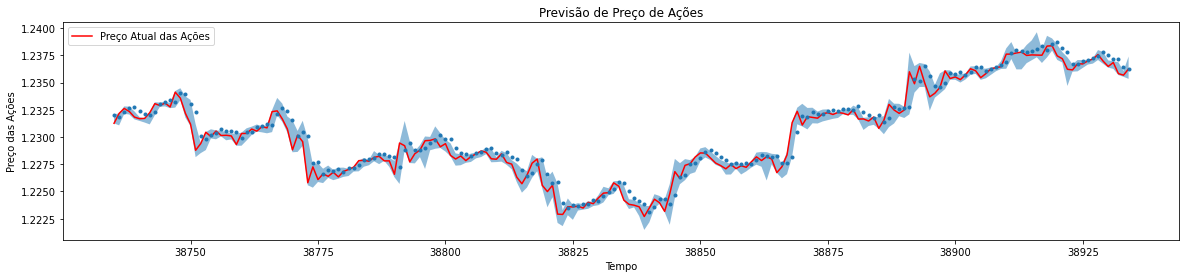

69.33490633964539


In [31]:
estatisticalTested.graphicMaxMin(200)

In [32]:
estatisticalTested.saveToCsv()